# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import cv2
import time
import random
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import interp
import albumentations as A
from shutil import copyfile
from IPython import display
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix as sk_cm

%matplotlib inline

In [2]:
from myutilitymethods import MyMethods
from mycnn import MyCNN

Using TensorFlow backend.


# Variables and Methods

In [3]:
class_to_num = {
    'Male': 0,
    'Female': 1
}

name_to_num = {
    'Myself': 0,
    'Sister': 1,
    'Mother': 1,
    'Father': 0
}

num_to_class = ['Male', 'Female']
class_colors = ['Blue', 'Hotpink']
NUM_CLASSES = len(num_to_class)

In [4]:
mm = MyMethods(NUM_CLASSES, num_to_class, class_to_num)

# Methods

In [5]:
def read_csv(filepath, aug_factor=10, print_progress=False, img_size=28):
    '''Takes in .csv and returns the compressed images's pixels in RGB format as Numpy array'''
    img = pd.read_csv(filepath, header=None).values
    return img.reshape(img.shape[0], img_size, img_size, 3)

In [6]:
def prepare_y(images_tuple):
    '''Prepare y set'''
    y_eklavya = [name_to_num['Myself']] * len(images_tuple[0])
    y_aranya = [name_to_num['Sister']] * len(images_tuple[1])
    y_mom = [name_to_num['Mother']] * len(images_tuple[2])
    y_dad = [name_to_num['Father']] * len(images_tuple[3])
    # Combine
    y = y_eklavya + y_aranya + y_mom + y_dad
    return np.array(y)

In [7]:
def prepare_x(images_tuple, hd=False):
    '''Prepare x set'''  
    x = np.concatenate(images_tuple, axis=0)
    x_hd = []
    if hd:
        x_hd = np.concatenate(images_tuple, axis=0)
    return x, x_hd

In [8]:
def plot_all_confusion_matrices(y_true, y_pred, y_true_val, y_pred_val, y_true_test, y_pred_test, 
                                classes, save_title, normalize=False, title=None, cmap='GnBu', dpi=150):
    '''Plot train, validation, and test confusion matrices'''
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrices'
        else:
            title = 'Non-Normalized Confusion Matrices'
    # Compute confusion matrix
    cm_train = sk_cm(y_true, y_pred)
    cm_val = sk_cm(y_true_val, y_pred_val)
    cm_test = sk_cm(y_true_test, y_pred_test)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize: 
        cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
        cm_val   = cm_val.astype('float')   / cm_val.sum(axis=1)  [:, np.newaxis]
        cm_test  = cm_test.astype('float')  / cm_test.sum(axis=1) [:, np.newaxis]
    # Lists  
    cms = [cm_train, cm_val, cm_test]
    titles = ['Train', 'Validation', 'Test']
    fig, axes = plt.subplots(nrows=1, ncols=3, dpi=dpi, figsize=(15, 8))
    # Loop
    for i, ax in enumerate(axes):
        im = ax.imshow(cms[i], interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
        # Label
        ax.set(xticks=np.arange(cms[i].shape[1]),
               yticks=np.arange(cms[i].shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=titles[i]
               )
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_yticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    # Loop
    for c, cm in enumerate(cms):
        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        # Loop
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[c].text(j, i, format(cm[i, j], fmt), 
                             ha="center", va="center", 
                             color="white" if cm[i, j] > thresh else "black")
    # For only one ax
    axes[0].set(ylabel='True label',)
    axes[1].set(xlabel='Predicted label')
    # Adjust
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.315, 0.025, 0.375]) # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    
    # Save
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    
    # Plot
    plt.show()

In [9]:
def make_fpr_tpr_auc_dicts(y, probs_list):
    '''Compute and return the ROC curve and ROC area for each class in dictionaries'''
    # Dicts
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    
    # For test
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y[:, i], probs_list[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), probs_list.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, thresholds, roc_auc

In [10]:
def plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.0025, 0.03), ylim=(0.99, 1.001), seed=0, save_title=None):
    '''Plot ROC AUC Curves'''
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,5))
    
    lw = 2
    axes[0].set_xlabel('False Positive Rate')
    axes[1].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    
    #if NUM_CLASSES!=4:
    #    class_colors = randomColorGenerator(NUM_CLASSES, seed)
    
    for i in range(NUM_CLASSES):
        axes[0].plot(fpr[i], tpr[i], color=class_colors[i], label='{0} ({1:0.2f}%)' ''.format(num_to_class[i], roc_auc[i]*100))
        axes[1].plot(fpr[i], tpr[i], color=class_colors[i], lw=lw, label='{0} ({1:0.2f}%)' ''.format(num_to_class[i], roc_auc[i]*100))
    
    axes[0].plot(fpr['micro'], tpr['micro'], label='Micro avg ({:0.2f}%)' ''.format(roc_auc['micro']*100), linestyle=':', color='orange')
    axes[0].plot(fpr['macro'], tpr['macro'], label='Macro avg ({:0.2f}%)' ''.format(roc_auc['macro']*100), linestyle=':', color='green')
    axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[0].scatter(0,1, label='Ideal', s=2)
    
    axes[1].plot(fpr['micro'], tpr['micro'], lw=lw, label='Micro avg ({:0.2f}%)'.format(roc_auc['micro']*100), linestyle=':', color='orange')
    axes[1].plot(fpr['macro'], tpr['macro'], lw=lw, label='Macro avg ({:0.2f}%)'.format(roc_auc['macro']*100), linestyle=':', color='green')
    axes[1].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[1].scatter(0,1, label='Ideal', s=50)
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    
    axes[0].grid(True, linestyle='dotted', alpha=1)
    axes[1].grid(True, linestyle='dotted', alpha=1)
    
    axes[0].legend(loc=4)
    axes[1].legend(loc=4)
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    plt.show()

In [11]:
def randomColorGenerator(number_of_colors=1, seed=0):
    '''Generate list of random colors'''
    np.random.seed(seed)
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(number_of_colors)]

# Import Data

In [12]:
%%time
# Read in raw data
myself_raw = read_csv('../input/familyfaces/Myself.csv')
sister_raw = read_csv('../input/familyfaces/Sister.csv')
mother_raw = read_csv('../input/familyfaces/Mother.csv')
father_raw = read_csv('../input/familyfaces/Father.csv')

CPU times: user 1.47 s, sys: 96 ms, total: 1.56 s
Wall time: 1.62 s


In [13]:
def process_data(raw_data_list, augs):
    processed_data = []
    batch = []
    for i, raw_data in enumerate(raw_data_list):
        for img in raw_data:
            img = mm.convertToRGB(img.astype('uint8'))
            img = mm.equalise_image(img, eq_type='HSV')
            imgs = mm.augment_images(img, augs[i])
            imgs = mm.standardise_images(imgs)
            batch.append(imgs)
        processed_data.append(np.concatenate(batch))
        batch = []
    return processed_data

In [14]:
# Process
raw_data_list = [myself_raw, sister_raw, mother_raw, father_raw]
augs = [5,5,10,15]
processed_data = process_data(raw_data_list, augs)

# Prepare datasets
images_tuple = tuple(processed_data)
raw_x, _ = prepare_x(images_tuple)
raw_y = prepare_y(images_tuple)

In [15]:
x, y = shuffle(raw_x, raw_y, random_state=0)
x_train, y_train, x_test, y_test = mm.split_train_test(x, y, split=0.95)

# Data Exploration

In [16]:
sets = ((x,y), (x_train, y_train), (x_test, y_test))

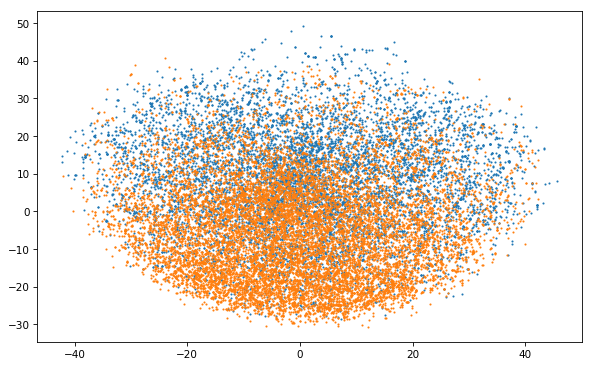

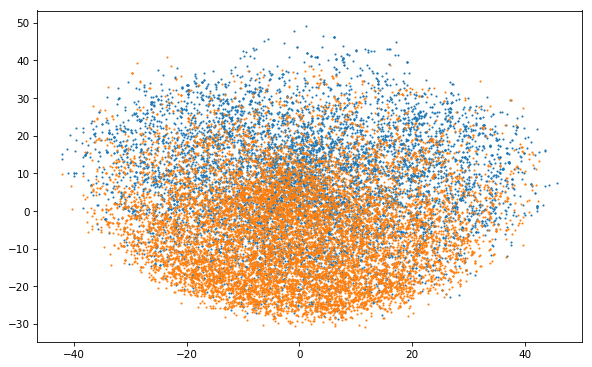

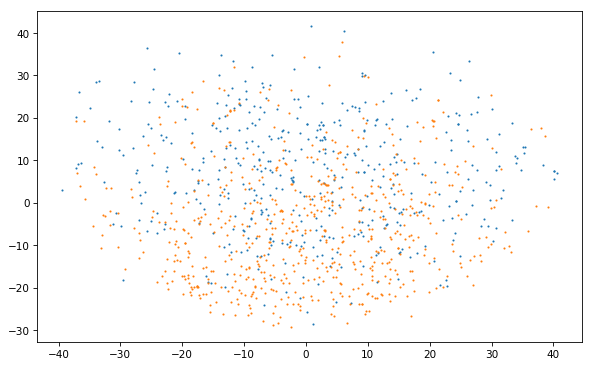

In [17]:
for my_set in sets:
    mm.plot_pca(my_set[0], my_set[1], dpi=75)

In [18]:
# Count
males_count = 0
females_count = 0
for y_i in y:
    if y_i == 0:
        males_count += 1
    else:
        females_count += 1

In [19]:
nbs = [males_count, females_count]
og_nbs = [len(myself_raw)+len(father_raw), len(sister_raw)+len(mother_raw)]

In [20]:
diff_nbs = []
for i,val in enumerate(og_nbs):
    diff_nbs.append(nbs[i]-og_nbs[i])

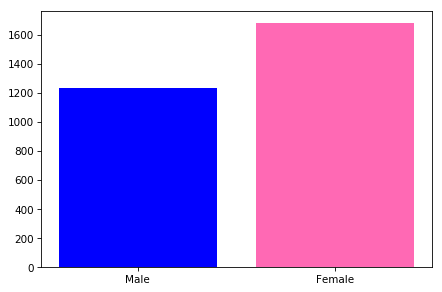

In [21]:
# W/o data aug
plt.figure(dpi=75)
plt.bar(num_to_class, og_nbs, color=class_colors)
plt.tight_layout()
plt.savefig('DataBarPlotwoAug.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

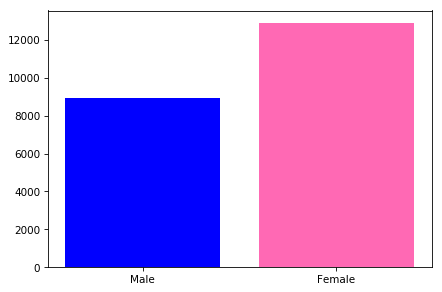

In [22]:
# W/data aug
plt.figure(dpi=75)
plt.bar(num_to_class, nbs, color=class_colors)
plt.tight_layout()
plt.savefig('DataBarPlotwAug.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

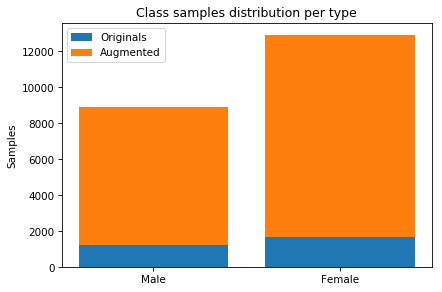

In [23]:
# Data aug distribution
plt.figure(dpi=75)

p1 = plt.bar(num_to_class, og_nbs)
p2 = plt.bar(num_to_class, diff_nbs, bottom=og_nbs)

plt.ylabel('Samples')
plt.title('Class samples distribution per type')
plt.legend((p1, p2), ('Originals', 'Augmented'))

plt.tight_layout()
plt.savefig('DataDoubleBarPlot.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

# Assert

In [24]:
# One-hot encode
if y_train.ndim == 1:
    y_train = mm.one_hot_encode(list(y_train))

if y_test.ndim == 1:
    y_test = mm.one_hot_encode(list(y_test))

In [25]:
# Assert shapes
assert(y_train.shape[1]==NUM_CLASSES)
assert(y_test.shape[1]==NUM_CLASSES)

In [26]:
# Assert std devs
assert(np.round(x_train[0].std(), 3) == 1)
assert(np.round(x_test[0].std(),  3) == 1)

In [27]:
# Assert means
assert(np.round(x_train[0].mean(), 3) == 0)
assert(np.round(x_test[0].mean(),  3) == 0)

# Model with k-fold cross validation

In [28]:
# Check
print('x_train :', x_train.shape)
print('y_train :', y_train.shape)
print('')
print('x_test  :', x_test.shape)
print('y_test  :', y_test.shape)

x_train : (20730, 28, 28, 3)
y_train : (20730, 2)

x_test  : (1092, 28, 28, 3)
y_test  : (1092, 2)


In [29]:
try:
  sess
except NameError:
    pass
else:
    sess.close()
tf.reset_default_graph()

# Setup model
model = MyCNN(x_train[:20700], 
              y_train[:20700], 
              x_test,
              y_test,
              output_dir='./Gender_logdir/',
              num_to_class=num_to_class, 
              class_to_num=class_to_num,
              lr=1e-5,
              nb_epochs=50, 
              batch_size_train=30,
              seed=0,
              final_activation='softmax')

# Initialise model
model.create_model()
model.compute_loss()
model.optimizer()
model.set_up_saver()
tf.initialize_all_variables().run(session=model.sess)

# Make path if necessary
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [30]:
model.model_variables()

x_train             : (20700, 28, 28, 3)
y_train             : (20700, 2)
x_test              : (1092, 28, 28, 3)
y_test              : (1092, 2)
output_dir          : ./Gender_logdir/
lr                  : 1e-05
nb_epochs           : 50
batch_size_train    : 30
seed                : 0
nb_classes          : 2
nb_images           : 20700
nb_train_iterations : 690
im                  : Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
labels              : Tensor("Placeholder_1:0", shape=(?, 2), dtype=float32)


In [31]:
model.model_summary()

first_layer  : conv2D  - (?, 25, 25, 32)
second_layer : conv2D  - (?, 11, 11, 64)
third_layer  : conv2D  - (?, 4, 4, 128)
fourth_layer : conv2D  - (?, 1, 1, 256)
flattened.   : Flatten - (?, 256)
logits       : Dense   - (?, 2)
preds        : Softmax - (?, 2)


In [32]:
# Train softmax model w/k-CV
model.train(verbose=False, cross_k_fold_validation=True)

In [33]:
# Test model
model.test()

Test accuracy achieved: 0.970


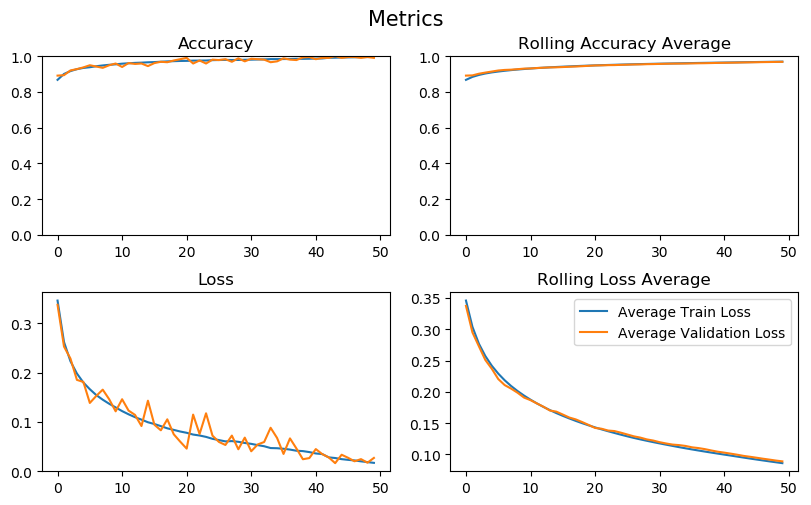

In [34]:
# Plot variables over training and validation set w/k-CV
mm.plot_metrics(model.accuracy_list, 
                model.losses_list, 
                model.val_accuracy_list, 
                model.val_losses_list,
                save_title='softmax_w_kCV_metrics')

In [35]:
# Get train metrics report
report = classification_report(np.argmax(model.y_train, axis=1), 
                               model.preds_list, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,precision,recall,f1-score,support
Male,1.00,0.99,0.99,8450.0
Female,0.99,1.00,1.00,12250.0
accuracy,1.00,1.00,1.00,1.0
macro avg,1.00,1.00,1.00,20700.0
weighted avg,1.00,1.00,1.00,20700.0


In [36]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Male         &       1.00 &    0.99 &      0.99 &   8450.0 \\
Female       &       0.99 &    1.00 &      1.00 &  12250.0 \\
accuracy     &       1.00 &    1.00 &      1.00 &      1.0 \\
macro avg    &       1.00 &    1.00 &      1.00 &  20700.0 \\
weighted avg &       1.00 &    1.00 &      1.00 &  20700.0 \\
\bottomrule
\end{tabular}



In [37]:
# Get validation metrics report
report = classification_report(np.argmax(model.y_val, axis=1), 
                               model.preds_list_val, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,precision,recall,f1-score,support
Male,0.99,0.98,0.99,183.00
Female,0.99,1.00,0.99,231.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,414.00
weighted avg,0.99,0.99,0.99,414.00


In [38]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Male         &       0.99 &    0.98 &      0.99 &   183.00 \\
Female       &       0.99 &    1.00 &      0.99 &   231.00 \\
accuracy     &       0.99 &    0.99 &      0.99 &     0.99 \\
macro avg    &       0.99 &    0.99 &      0.99 &   414.00 \\
weighted avg &       0.99 &    0.99 &      0.99 &   414.00 \\
\bottomrule
\end{tabular}



In [39]:
# Get test metrics report
report = classification_report(np.argmax(model.y_test, axis=1), 
                               model.preds_list_test, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,precision,recall,f1-score,support
Male,0.98,0.95,0.96,456.00
Female,0.97,0.98,0.97,636.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.97,0.97,0.97,1092.00
weighted avg,0.97,0.97,0.97,1092.00


In [40]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Male         &       0.98 &    0.95 &      0.96 &   456.00 \\
Female       &       0.97 &    0.98 &      0.97 &   636.00 \\
accuracy     &       0.97 &    0.97 &      0.97 &     0.97 \\
macro avg    &       0.97 &    0.97 &      0.97 &  1092.00 \\
weighted avg &       0.97 &    0.97 &      0.97 &  1092.00 \\
\bottomrule
\end{tabular}



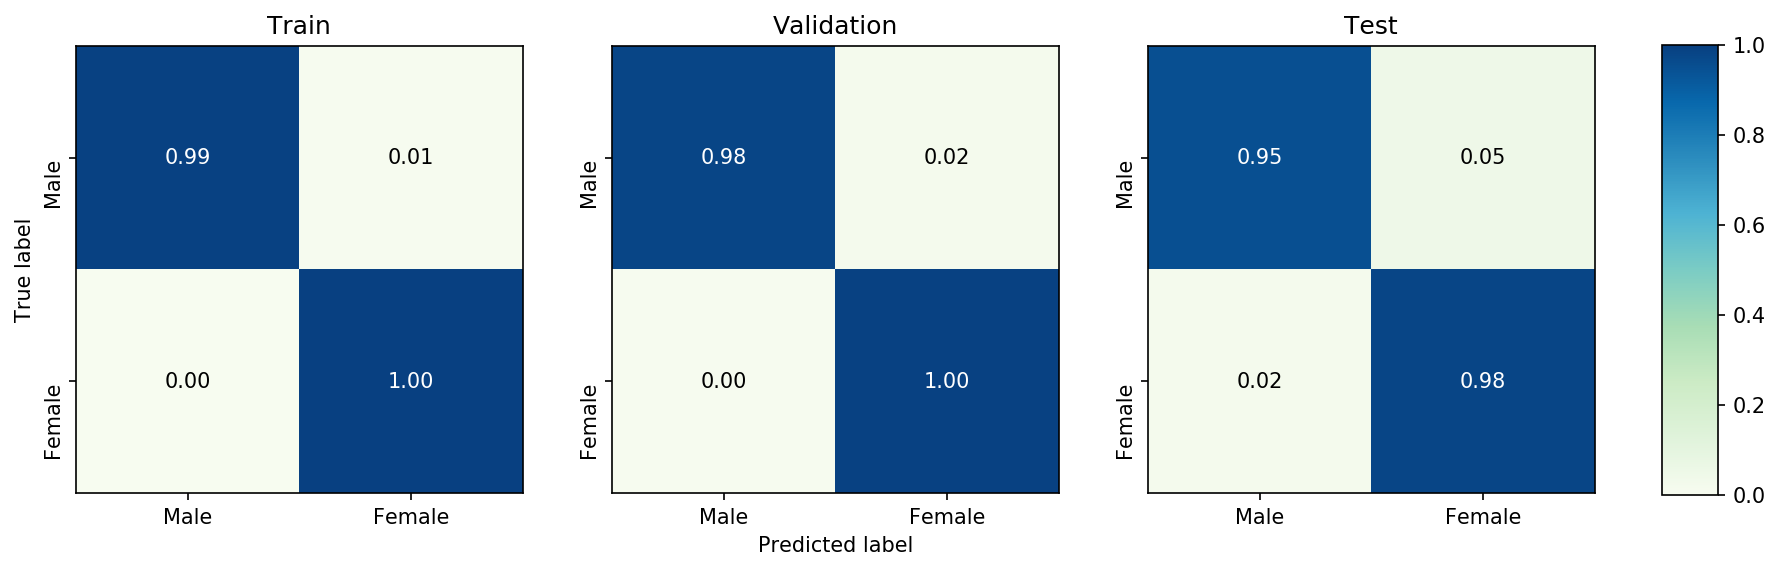

In [41]:
# Plot CMs w/k-CV
plot_all_confusion_matrices(np.argmax(model.y_train, axis=1), model.preds_list,
                            np.argmax(model.y_val, axis=1),   model.preds_list_val,
                            np.argmax(model.y_test, axis=1),  model.preds_list_test,
                            np.array(num_to_class), 'CM_softmax_w_kCV', normalize=True)

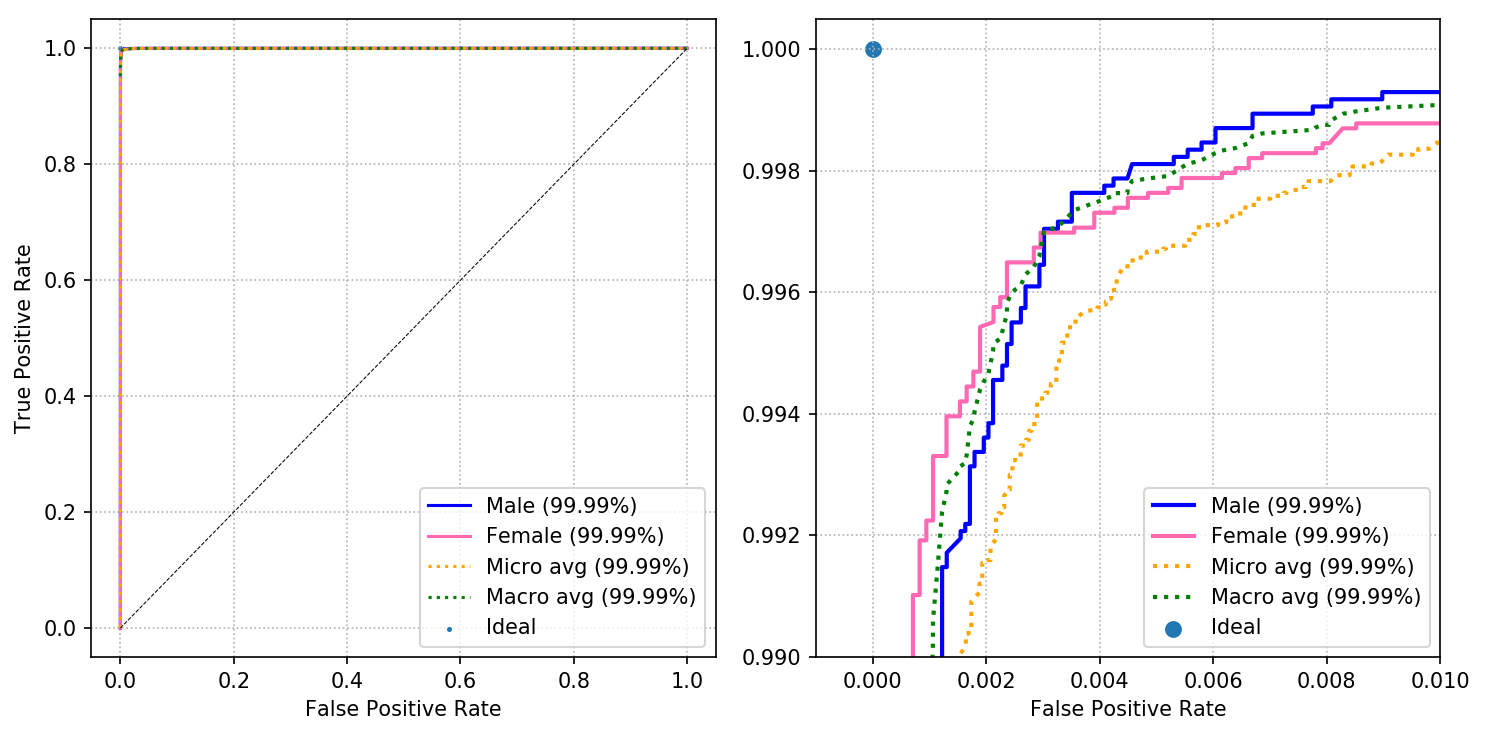

In [42]:
# Train ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_train, model.probs_list)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.001, 0.01), ylim=(0.99, 1.0005), seed=1, save_title='Softmax_TrainROC_w_kCV')

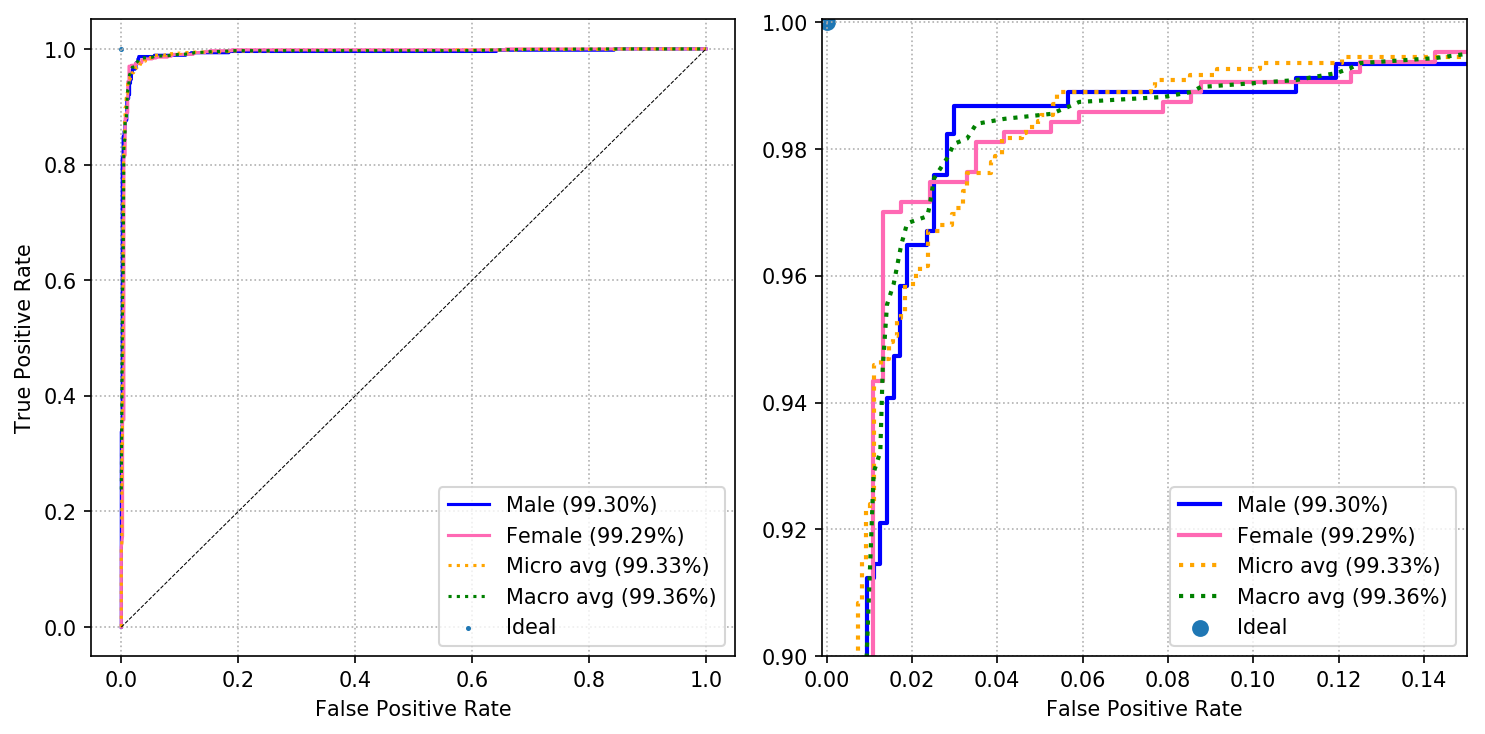

In [43]:
# Test ROC/AUC w/k-cross val
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_test, model.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.001, 0.15), ylim=(0.9, 1.0005), seed=1, save_title='Softmax_TestROC_w_kCV')

In [44]:
model.sess.close()

# Sigmoid Model

In [45]:
try:
  sess
except NameError:
    pass
else:
    sess.close()
tf.reset_default_graph()

# Setup model
model_2 = MyCNN(x_train[:20700], 
                y_train[:20700], 
                x_test,
                y_test,
                output_dir='./Gender_logdir/',
                num_to_class=num_to_class, 
                class_to_num=class_to_num,
                lr=1e-5,
                nb_epochs=50, 
                batch_size_train=30,
                seed=0,
                final_activation='sigmoid')

# Initialise model_2
model_2.create_model()
model_2.compute_loss()
model_2.optimizer()
model_2.set_up_saver()
tf.initialize_all_variables().run(session=model_2.sess)

# Make path if necessary
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

In [46]:
model.model_variables()

x_train             : (20700, 28, 28, 3)
y_train             : (20700, 2)
x_test              : (1092, 28, 28, 3)
y_test              : (1092, 2)
output_dir          : ./Gender_logdir/
lr                  : 1e-05
nb_epochs           : 50
batch_size_train    : 30
seed                : 0
nb_classes          : 2
nb_images           : 20700
nb_train_iterations : 690
im                  : Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
labels              : Tensor("Placeholder_1:0", shape=(?, 2), dtype=float32)


In [47]:
model.model_summary()

first_layer  : conv2D  - (?, 25, 25, 32)
second_layer : conv2D  - (?, 11, 11, 64)
third_layer  : conv2D  - (?, 4, 4, 128)
fourth_layer : conv2D  - (?, 1, 1, 256)
flattened.   : Flatten - (?, 256)
logits       : Dense   - (?, 2)
preds        : Softmax - (?, 2)


In [48]:
# Train sigmoid model w/k-CV
model_2.train(verbose=False, cross_k_fold_validation=True)

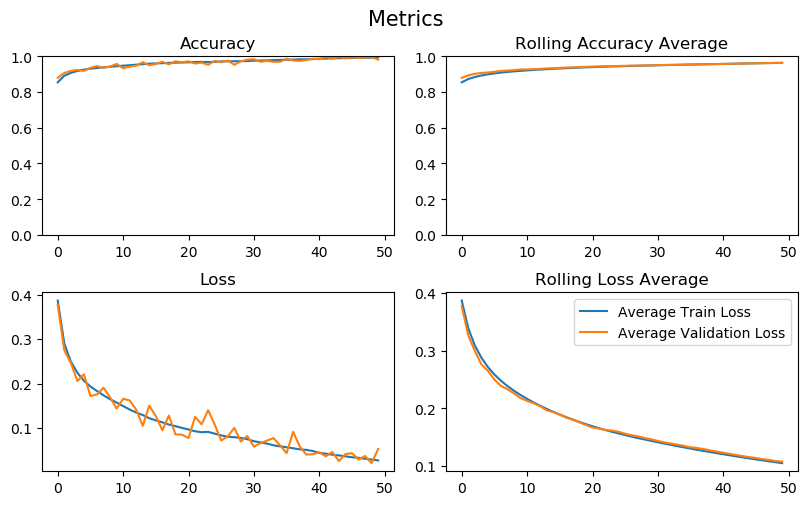

In [49]:
# Plot variables over training and validation set w/k-CV
mm.plot_metrics(model_2.accuracy_list, 
                model_2.losses_list, 
                model_2.val_accuracy_list, 
                model_2.val_losses_list,
                save_title='sigmoid_w_kCV_metrics')

In [50]:
model_2.test()

Test accuracy achieved: 0.973


In [51]:
# Get train metrics report
report = classification_report(np.argmax(model_2.y_train, axis=1), 
                               model_2.preds_list, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,precision,recall,f1-score,support
Male,0.99,0.99,0.99,8450.00
Female,0.99,0.99,0.99,12250.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,20700.00
weighted avg,0.99,0.99,0.99,20700.00


In [52]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &   support \\
\midrule
Male         &       0.99 &    0.99 &      0.99 &   8450.00 \\
Female       &       0.99 &    0.99 &      0.99 &  12250.00 \\
accuracy     &       0.99 &    0.99 &      0.99 &      0.99 \\
macro avg    &       0.99 &    0.99 &      0.99 &  20700.00 \\
weighted avg &       0.99 &    0.99 &      0.99 &  20700.00 \\
\bottomrule
\end{tabular}



In [53]:
# Get validation metrics report
report = classification_report(np.argmax(model_2.y_val, axis=1), 
                               model_2.preds_list_val, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,precision,recall,f1-score,support
Male,0.98,0.97,0.98,183.00
Female,0.98,0.99,0.98,231.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,414.00
weighted avg,0.98,0.98,0.98,414.00


In [54]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Male         &       0.98 &    0.97 &      0.98 &   183.00 \\
Female       &       0.98 &    0.99 &      0.98 &   231.00 \\
accuracy     &       0.98 &    0.98 &      0.98 &     0.98 \\
macro avg    &       0.98 &    0.98 &      0.98 &   414.00 \\
weighted avg &       0.98 &    0.98 &      0.98 &   414.00 \\
\bottomrule
\end{tabular}



In [55]:
# Get test metrics report
report = classification_report(np.argmax(model_2.y_test, axis=1), 
                               model_2.preds_list_test,
                               target_names=class_to_num,
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,precision,recall,f1-score,support
Male,0.97,0.96,0.97,456.00
Female,0.97,0.98,0.98,636.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.97,0.97,0.97,1092.00
weighted avg,0.97,0.97,0.97,1092.00


In [56]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Male         &       0.97 &    0.96 &      0.97 &   456.00 \\
Female       &       0.97 &    0.98 &      0.98 &   636.00 \\
accuracy     &       0.97 &    0.97 &      0.97 &     0.97 \\
macro avg    &       0.97 &    0.97 &      0.97 &  1092.00 \\
weighted avg &       0.97 &    0.97 &      0.97 &  1092.00 \\
\bottomrule
\end{tabular}



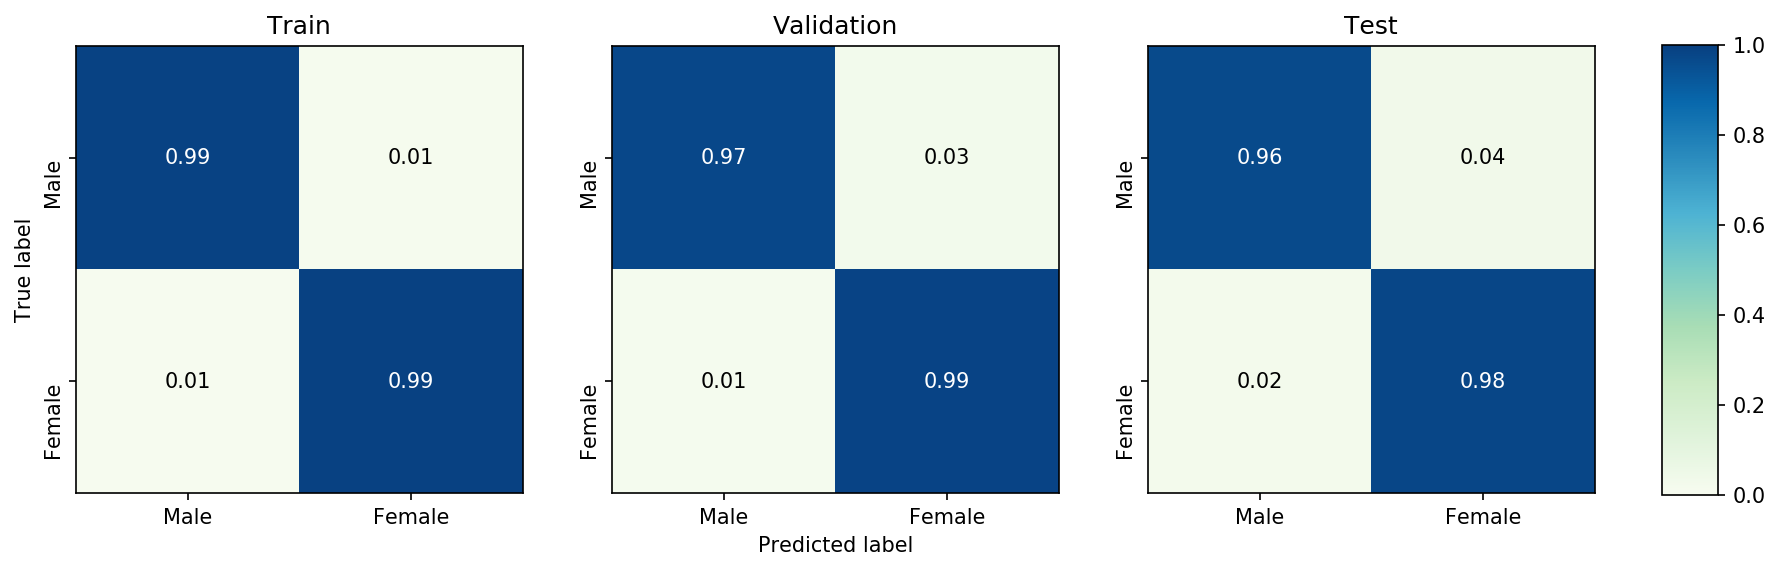

In [57]:
# Plot CMs w/k-CV
plot_all_confusion_matrices(np.argmax(model_2.y_train, axis=1), model_2.preds_list,
                            np.argmax(model_2.y_val, axis=1),   model_2.preds_list_val,
                            np.argmax(model_2.y_test, axis=1),  model_2.preds_list_test,
                            np.array(num_to_class), 'CM_sigmoid_w_kCV', normalize=True)

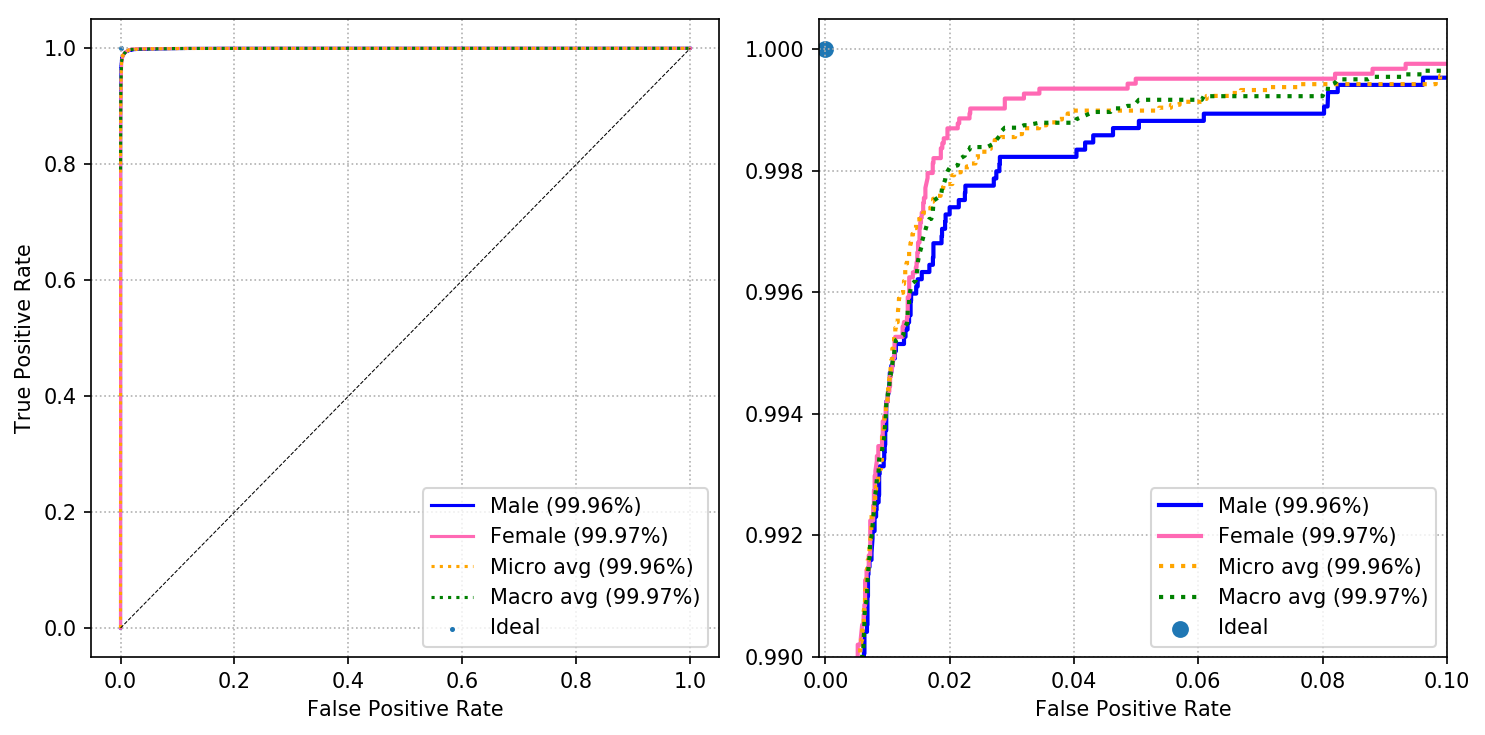

In [58]:
# Train ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model_2.y_train, model_2.probs_list)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.001, 0.1), ylim=(0.99, 1.0005), seed=1, save_title='Sigmoid_TrainROC_w_kCV')

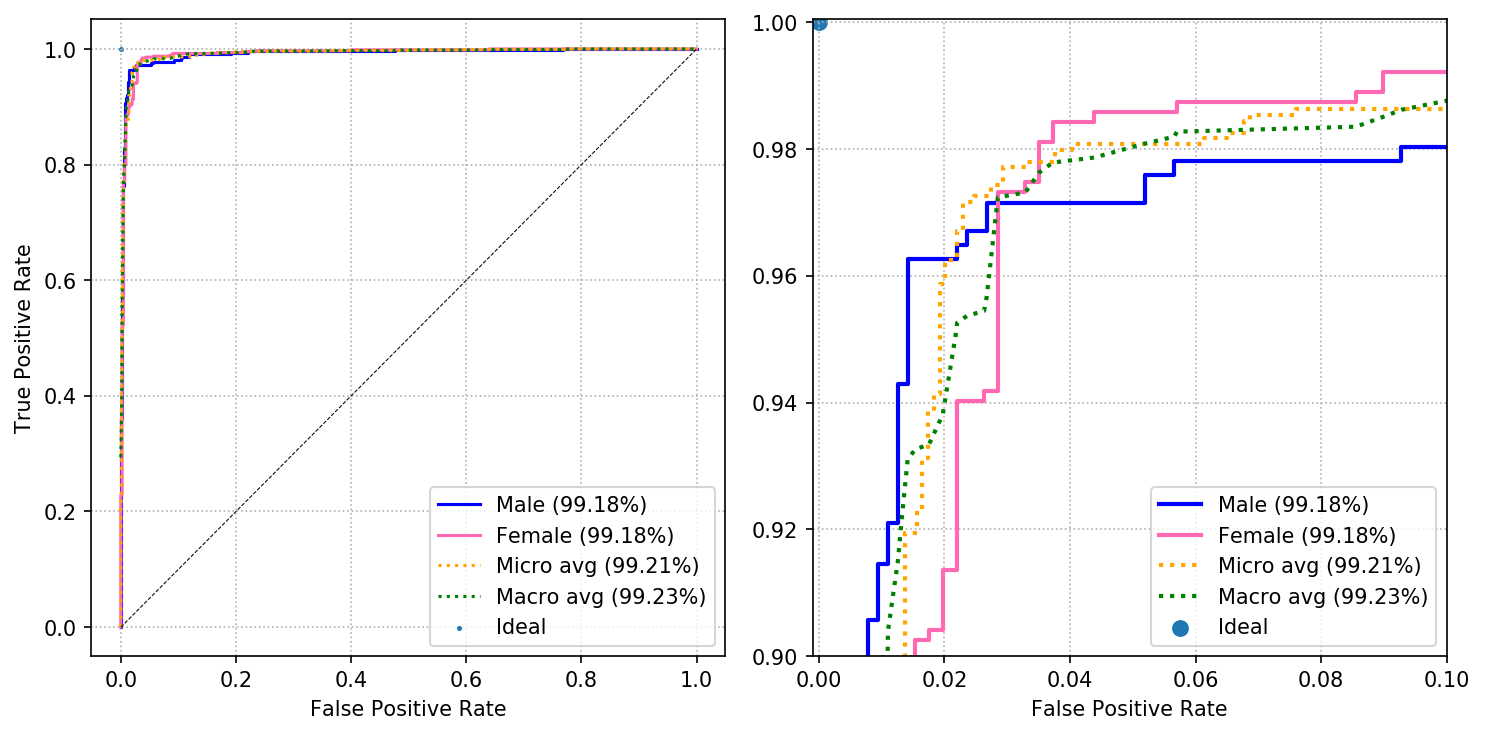

In [59]:
# Test ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model_2.y_test, model_2.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.001, 0.1), ylim=(0.9, 1.0005), seed=1, save_title='Sigmoid_TestROC_w_kCV')

In [60]:
model.sess.close()

## Compare

In [61]:
def compare_roc_auc_curves(fpr, tpr, roc_auc, fpr_2, tpr_2, roc_auc_2, xlim=(-0.0025, 0.03), ylim=(0.99, 1.001)):
    '''Plot ROC AUC Curves'''
    fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(8,8))
    
    lw = 2
    #axes[0][0].set_xlabel('False Positive Rate')
    #axes[1][0].set_xlabel('False Positive Rate')
    #axes[2][0].set_xlabel('False Positive Rate')
    #axes[0].set_ylabel('True Positive Rate')
    
    c=0
    for i in range(len(axes)-1):
        for j in range(len(axes[0])):
            axes[i][j].set_title(num_to_class[c])
            axes[i][j].plot(fpr[c], tpr[c], lw=1, label='{0} ({1:0.2f}%)' ''.format('Softmax', roc_auc[c]*100))
            axes[i][j].plot(fpr_2[c], tpr_2[c], lw=1, label='{0} ({1:0.2f}%)' ''.format('Sigmoid', roc_auc[c]*100))
            c += 1
    
    axes[1][0].set_title('Micro avg') 
    #axes[0].plot(fpr['micro'], tpr['micro'], label='Micro avg (%0.2f)' % roc_auc['micro'], linestyle=':', color='deeppink')
    axes[1][0].plot(fpr['micro'], tpr['micro'], label='Softmax ({:0.2f}%)' ''.format(roc_auc['micro']*100), linestyle=':')
    axes[1][0].plot(fpr_2['micro'], tpr_2['micro'], label='Sigmoid ({:0.2f}%)' ''.format(roc_auc_2['micro']*100), linestyle=':')
    #axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    
    axes[1][1].set_title('Macro avg')
    #axes[1].plot(fpr['micro'], tpr['micro'], lw=lw, label='Micro avg (%0.2f)' % roc_auc['micro'], linestyle=':', color='deeppink')
    axes[1][1].plot(fpr['macro'], tpr['macro'], label='Softmax ({:0.2f}%)' ''.format(roc_auc['macro']*100), linestyle=':')
    axes[1][1].plot(fpr_2['macro'], tpr_2['macro'], label='Sigmoid ({:0.2f}%)' ''.format(roc_auc_2['macro']*100), linestyle=':')
    #axes[1].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            axes[i][j].set_xlim(xlim)
            axes[i][j].set_ylim(ylim)
            axes[i][j].grid(True, linestyle='dotted', alpha=1)
            axes[i][j].grid(True, linestyle='dotted', alpha=1)
            axes[i][j].legend(loc=4)
            axes[i][j].legend(loc=4)
            axes[i][j].scatter(0,1, s=25)
    
    plt.legend(loc="lower right")
    fig.tight_layout() 
    fig.savefig('CombinedTestROCPerClass.pdf', bbox_inches='tight', format='pdf', dpi=200)
    plt.show()

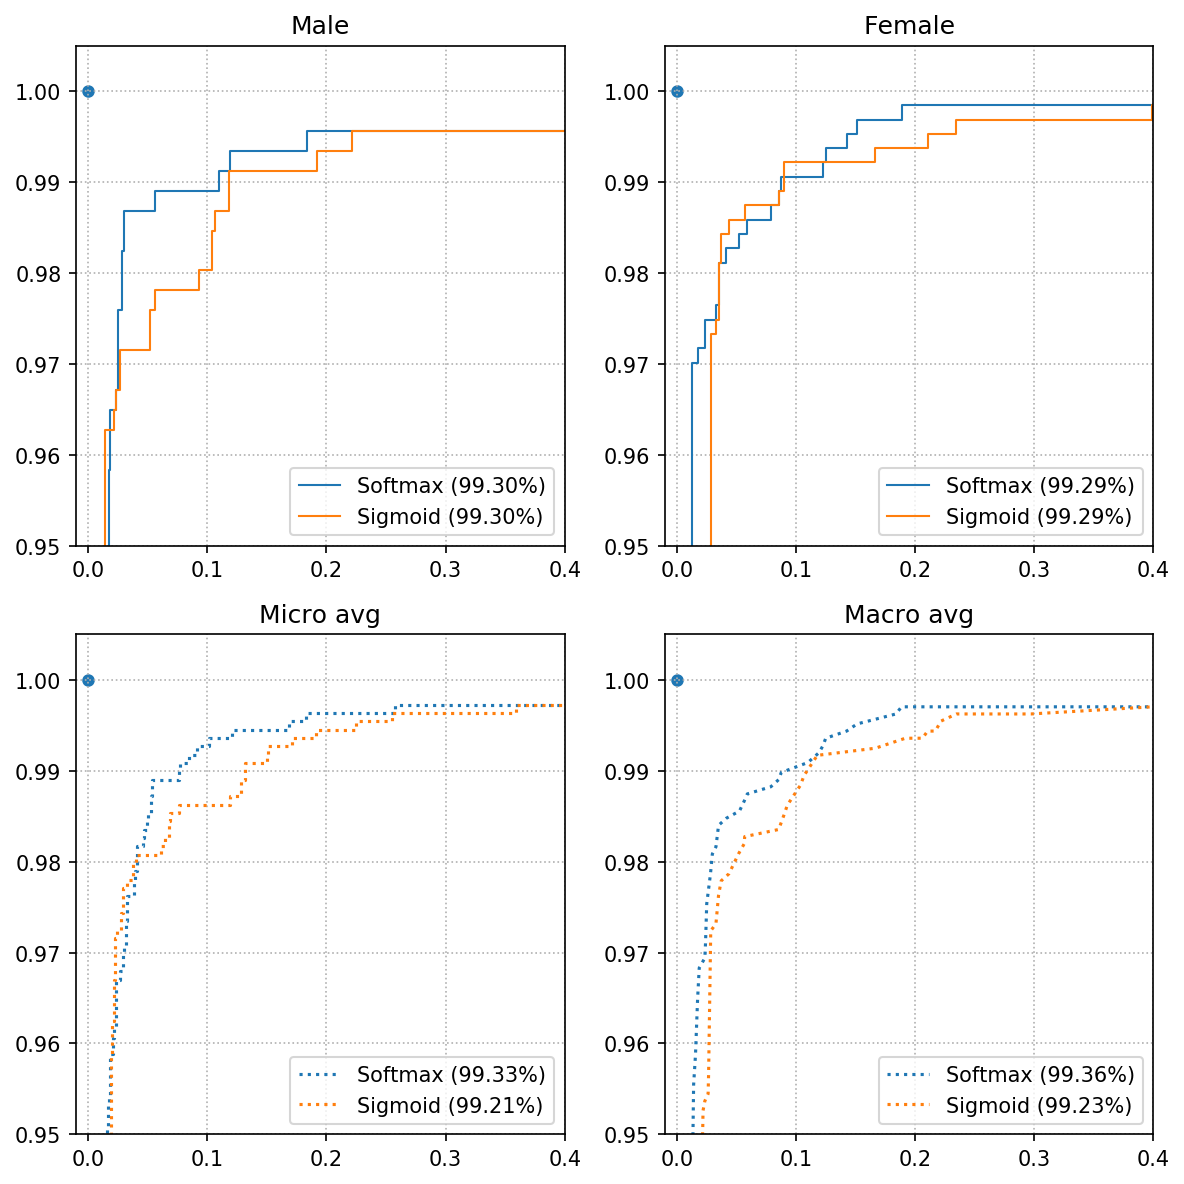

In [62]:
# Compare Test ROC/AUCs
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_test, model.probs_list_test)
fpr_2, tpr_2, thresholds_2, roc_auc_2 = make_fpr_tpr_auc_dicts(model_2.y_test, model_2.probs_list_test)

compare_roc_auc_curves(fpr, tpr, roc_auc, fpr_2, tpr_2, roc_auc_2, xlim=(-0.01, 0.4), ylim=(0.95, 1.005))

In [63]:
# Compare Test AUC values
df = pd.DataFrame([roc_auc, roc_auc_2], index=['Softmax', 'Sigmoid'])
df.columns=['Male', 'Female', 'Micro', 'Macro']
df = df.T
df

,Softmax,Sigmoid
Male,0.992962,0.991752
Female,0.992945,0.991792
Micro,0.993320,0.992072
Macro,0.993605,0.992296


In [64]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &   Softmax &   Sigmoid \\
\midrule
Male   &  0.992962 &  0.991752 \\
Female &  0.992945 &  0.991792 \\
Micro  &  0.993320 &  0.992072 \\
Macro  &  0.993605 &  0.992296 \\
\bottomrule
\end{tabular}



## Accuracy Score

In [65]:
def binary_classfication_report(y, probs):
    
    # Variables
    y_true = np.argmax(y, axis=1)
    y_hat = np.argmax(probs, axis=1)
    y_scores = probs[:,1]
    
    y_true_2 = 1-y_true
    y_hat_2 = 1-y_hat
    y_scores_2 =probs[:,0]
    
    report = {
        'Male': {
            'f1_score': metrics.f1_score(y_true, y_hat),
            'balanced_acc': metrics.balanced_accuracy_score(y_true, y_hat),
            'avg_precision': metrics.average_precision_score(y_true, y_hat),
            'brier_loss' : metrics.brier_score_loss(y_true, y_scores),
            'log_loss': metrics.log_loss(y_true, y_hat),
            'precision': metrics.precision_score(y_true, y_hat),
            'recall': metrics.recall_score(y_true, y_hat)
        }, 
        
        'Female': {
            'f1_score': metrics.f1_score(y_true_2, y_hat_2),
            'balanced_acc': metrics.balanced_accuracy_score(y_true_2, y_hat_2),
            'avg_precision': metrics.average_precision_score(y_true_2, y_hat_2),
            'brier_loss' : metrics.brier_score_loss(y_true_2, y_scores_2),
            'log_loss': metrics.log_loss(y_true_2, y_hat_2),
            'precision': metrics.precision_score(y_true_2, y_hat_2),
            'recall': metrics.recall_score(y_true_2, y_hat_2)
        },
        
        'accuracy': metrics.accuracy_score(y_true, y_hat),
        'roc_auc': metrics.roc_auc_score(y_true, y_hat),
    }
    
    return report    

In [66]:
k = binary_classfication_report(model.y_test, model.probs_list_test)
my_df = pd.DataFrame.from_dict(k).T.round(2)
my_df

,f1_score,balanced_acc,avg_precision,brier_loss,log_loss,precision,recall
Male,0.97,0.97,0.96,0.02,1.04,0.97,0.98
Female,0.96,0.97,0.95,0.02,1.04,0.98,0.95
accuracy,0.97,0.97,0.97,0.97,0.97,0.97,0.97
roc_auc,0.97,0.97,0.97,0.97,0.97,0.97,0.97


In [67]:
print(my_df.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  f1\_score &  balanced\_acc &  avg\_precision &  brier\_loss &  log\_loss &  precision &  recall \\
\midrule
Male     &      0.97 &          0.97 &           0.96 &        0.02 &      1.04 &       0.97 &    0.98 \\
Female   &      0.96 &          0.97 &           0.95 &        0.02 &      1.04 &       0.98 &    0.95 \\
accuracy &      0.97 &          0.97 &           0.97 &        0.97 &      0.97 &       0.97 &    0.97 \\
roc\_auc  &      0.97 &          0.97 &           0.97 &        0.97 &      0.97 &       0.97 &    0.97 \\
\bottomrule
\end{tabular}



In [68]:
k = binary_classfication_report(model_2.y_test, model_2.probs_list_test)
my_df = pd.DataFrame.from_dict(k).T.round(2)
my_df

,f1_score,balanced_acc,avg_precision,brier_loss,log_loss,precision,recall
Male,0.98,0.97,0.97,0.02,0.92,0.97,0.98
Female,0.97,0.97,0.95,0.02,0.92,0.97,0.96
accuracy,0.97,0.97,0.97,0.97,0.97,0.97,0.97
roc_auc,0.97,0.97,0.97,0.97,0.97,0.97,0.97


In [69]:
print(my_df.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  f1\_score &  balanced\_acc &  avg\_precision &  brier\_loss &  log\_loss &  precision &  recall \\
\midrule
Male     &      0.98 &          0.97 &           0.97 &        0.02 &      0.92 &       0.97 &    0.98 \\
Female   &      0.97 &          0.97 &           0.95 &        0.02 &      0.92 &       0.97 &    0.96 \\
accuracy &      0.97 &          0.97 &           0.97 &        0.97 &      0.97 &       0.97 &    0.97 \\
roc\_auc  &      0.97 &          0.97 &           0.97 &        0.97 &      0.97 &       0.97 &    0.97 \\
\bottomrule
\end{tabular}

